In [1]:
# For running the notebook on Google Colab, uncomment the following lines of code.

# ! pip install evaluate

# from google.colab import drive
# drive.mount('/content/drive')

# %cd /content/drive/MyDrive/CSMM-pipeline

# Model Training

After the classification scheme is fixed and a subset of the data has been annotated with human raters, we can train a classifier to scale up the labeling to the entire corpus with often millions of texts. In this notebook we cover:
1. The use of Large Language Models (LLMs) for classification tasks.
2. Evaluating model performance during and after training.
3. Common training strategies like Masked Language Modeling (MLM) and hyperparameter tuning.
4. A new strategy - Training on Confident Examples - that can be used should model performance still plateau.

## Selecting an Adequate Base Model

### LLMs and Traditional Transformer Models as Classifiers

With the advancement of Large Language Models such as OpenAI's GPT, Google's Gemini or Anthropic's Claude, these models have become feasible to achieve a variety of natural language processing tasks apart from question answering including text classification.

In the following, we will demonstrate a possible text classification workflow using OpenAI's GPT-4 in three common settings:
1. <b>Zero-shot with codebook</b>: Providing the LLM class definitions, but no labeled examples.
2. <b>Few-shot without codebook</b>: Providing the LLM labeled examples, but no class definitions.
3. <b>Few-shot with codebook</b>: Providing the LLM both the class definitions, and labeled examples.

We further estimate the performance of GPT-4 in all three settings using a set of 100 labeled tweets. The annotation task is identifying whether the writer of the tweet addresses their ingroup or outgroup in an inclusionary or exclusionary way. In order to classify texts with GPT, the user needs to have an OpenAI account and an API Key. However, to make the code accessible for everyone, we saved the results of our experiments for the user to retrieve. The remaining code is example code that can be transferred to any LLM classification workflow including open-source or open weights models like Kimi.

In [2]:
from openai import OpenAI
import pandas as pd
import json
from tqdm import tqdm
from sklearn.metrics import f1_score

In [3]:
# In order to run (some part of) this code, please insert your personal Open AI API Key here
# Note: The code also runs flawlessly without.
client = OpenAI(api_key="YOUR API KEY HERE")

#### How to create an API key?

If you do not have an OpenAI API Key, but would like to create one, do the following:
1. Go to https://platform.openai.com and log in or create a new account.
2. Under "API Keys" on the left, select "+ Create new secret key".
3. To connect to the API, add funds to your account. You can add funds under "Settings" > "Billing". A few dollars is more than enough to run our example code. For more information on pricing, visit https://openai.com/api/pricing/.

First, we define the codebook for prompting GPT-4, and assign numerical to natural language codes for the classes, we'd like GPT-4 to identify.

In [4]:
CODEBOOK = "You are a data labeler, here are the labels and instructions of each label:\n\n\
1: exclusionary about outgroup'; which is assigned if the text points out realistic \
or unrealistic threats from the outgroup, or if the text makes members of the \
outgroup look stupid\n\
'0: inclusionary about in/both groups'; which is assigned if the text highlights \
positive characteristics of the ingroup or justifies their actions, or if the \
text is pointing out common characteristics or challenges of in- and outgroup\n\
'2: other'; which is assigned if the text does not have in- or outgroup thinking, \
or if the text has signs of in- or outgroup thinking, but the speaker's affiliation \
is not apparent.\n"

In [5]:
GOAL_MAP = {0: "inclusionary about in/both groups",
            1: "exclusionary about out-group",
            2: "other"}

Now, we load the training and the test data. In this case, the training set are samples that we randomly draw from to provide examples to GPT-4 while prompting. The test set are samples that GPT-4 is supposed to annotate and where we know the true label based on human annotation.

In [6]:
def read_goal_data():
    training_data = pd.read_csv("data/goal_train_for_LLM.csv", delimiter=";")
    test_data = pd.read_csv("data/goal_test_for_LLM.csv", delimiter=";")

    return training_data, test_data

In [7]:
train, test = read_goal_data()

In [8]:
# Let's quickly inspect the data
print(f"The training data has {len(train)} entries.")
train.head(2)

The training data has 1821 entries.


,tweet_id,label,text
0,1000344534092537856,1,Am besten kippen wir die ganze deutsche Sprach...
1,1000634556972716032,1,Ihr habt doch auch nicht alle Schrauben locker...


In [9]:
print(f"The test data has {len(test)} entries.")
train.head(2)

The test data has 766 entries.


,tweet_id,label,text
0,1000344534092537856,1,Am besten kippen wir die ganze deutsche Sprach...
1,1000634556972716032,1,Ihr habt doch auch nicht alle Schrauben locker...


To run the code smoothly, we define some helper functions, specifically for (1) randomly selecting samples of the training data to show to GPT in a few shot setting, (2) randomly selecting samples from the test data to label 100 tweets in total, (3) inferring numerical labels from GPT's response text (which could be messy), and (4) computing the F1 score for GPT-4 as classifier on the 100 labeled tweets.

In [10]:
# Helper functions

def choose_random_training_sample(training_data):
    """ Chooses random examples for all three classes from the training data for prompting """
    df0 = training_data.query('label==0').sample(n=1)
    df1 = training_data.query('label==1').sample(n=1)
    df2 = training_data.query('label==2').sample(n=1)
    
    return pd.concat([df0, df1, df2])

def choose_random_test_sample(test_data):
    """ Draws one sample from the test data for labeling """
    df0 = test_data.sample(n=1)
    
    return df0

def infer_labels_from_response_text(resp_data):
    """ Extracts numerical labels from GPT-4s response messages """
    if "0" in resp_data["response_message"] or "inclusionary" in resp_data["response_message"]:
        label = "0"
    elif "1" in resp_data["response_message"] or "exclusionary" in resp_data["response_message"]:
        label = "1"
    elif "2" in resp_data["response_message"] or "other" in resp_data["response_message"]:
        label = "2"
    else:
        print("Label not found!", resp_data["response_message"])

    return label

def compute_F1_scores(filename):
    """ Computes the micro and macro F1 scores for GPT-4s performance """
    y_true = []
    y_pred = [] 
    with open(filename) as f:
        for line in f:
            resp_data = json.loads(line)
            predicted_label = infer_labels_from_response_text(resp_data)
            y_true.append(resp_data["true_label"])
            y_pred.append(predicted_label)
            
    print("macro", f1_score(y_true, y_pred, average='macro'))
    print("micro", f1_score(y_true, y_pred, average='micro'))

To illustrate, let's print an exemplary prompt for GPT-4 in a few shot setting, without codebook.

In [11]:
def few_shot_prompting_ex(training_data, test_data):

    training_data, test_data = read_goal_data()

    random_few_shot_training = choose_random_training_sample(training_data)
    test_sample = choose_random_test_sample(test_data)

    print("You are a data labeler, here are the labels:\n\n\
0: inclusionary about in or both groups\n\
1: exclusionary about out-group\n\
2: other\n\n\
Here are a few examples:\n")

    for _, row in random_few_shot_training.iterrows():
        print(row["text"], f"// This is labeled as {GOAL_MAP[row['label']]}.")

    print("\nPlease label this message:", test_sample["text"].values[0])\
    
    print("\n***TRUE LABEL***", test_sample["label"].values[0])

In [12]:
few_shot_prompting_ex(train, test)

You are a data labeler, here are the labels:

0: inclusionary about in or both groups
1: exclusionary about out-group
2: other

Here are a few examples:

@fakenewsde Feiges Land, ey! Wir ham nur die eine Erde – und dann nix cooleres zu machen als Leute zu kriminalisieren! // This is labeled as inclusionary about in/both groups.
Typisches Denken von Neuländern mit "negativem Wissen". Das glauben nur sozialistische, statisch-planwirtschaftlich denkende Gutmenschen. Merke: In der Marktwirtschaft bestimmen Angebot und Nachfrage den Preis. Alles andere ist politisch-wissenschaftlicher Quatsch. Zum Heulen, diese Jouris! @randomuser123 // This is labeled as exclusionary about out-group.
@Sternblick Galaxie - All - Universum ... // This is labeled as other.

Please label this message: Wo Muslime sind, gibt's irgendwie immer Stress.

***TRUE LABEL*** 1


Now, we run three experiments to evaluate GPT-4s performance in different settings: 1) Zero shot with codebook, 2) Few shot without codebook, 3) Few shot with codebook.

#### Zero shot with codebook

In [13]:
def zero_shot_with_codebook(training_data, test_data):
    test_sample = choose_random_test_sample(test_data)

    extra_instr = "Using these labels and instructions please label the following text: "

    # make the API call
    response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {
                    "role": "system",
                    "content": CODEBOOK  # provide the codebook as system message
                    },
                    {
                    "role": "user",
                    "content": extra_instr + test_sample["text"].values[0]  # provide the labeling prompt as user message
                    },
                ],
                temperature=1,  # controls the "randomness" of GPT's output
                max_tokens=256,  # maximum of tokens that GPT generates as output
                top_p=1,  # ranges between 0 and 1, number of eligible tokens that GPT considers for its output
                frequency_penalty=0,  # penalty for repeating words in the output
                presence_penalty=0  # penality for using tokens in the output that have appeared before
                )
    
    print(response)
    print("\n\n****TRUE LABEL***",test_sample["label"].values[0])

    # returns the full response message, the true label of the tweet, and the tweet id as a dictionary
    return {"response_message": response.choices[0].message.content,
            "true_label": str(test_sample["label"].values[0]),
            "tweet_id": str(test_sample["tweet_id"].values[0])}

In [14]:
"""
Experiment 1: 100 trials
Zero Shot: codebook provided but no examples

Note: The following code reads the results from our experiments. To rerun the experiment,
un-comment the code. You might want to choose another file name to separate your results from
ours before running the code. API KEY NEEDED.
"""

trials = 100
output_file_name = "results/zero_shot_w_code.jsona"

#for i in tqdm(range(trials), total=trials):
#    predicted_label = zero_shot_with_codebook(train, test)
    
#    with open(output_file_name, "a") as f:
#        json.dump(predicted_label, f)
    
#    with open(output_file_name, "a") as f:
#        f.write("\n")

compute_F1_scores(output_file_name)

macro 0.5017320339563031
micro 0.6


In [15]:
# Run this cell for an example output
# Comment out if API Key not available
# zero_shot_with_codebook(train, test)

#### Few shot without codebook

In [16]:
def few_shot_without_codebook(training_data, test_data):
    random_few_shot_training = choose_random_training_sample(training_data)
    test_sample = choose_random_test_sample(test_data)
    examples_str = ""

    for _, row in random_few_shot_training.iterrows():
        examples_str = examples_str + row["text"] + f" // This is labeled as {GOAL_MAP[row['label']]}.\n"

    # make the API call
    response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {
                    "role": "system",
                    "content": "You are a data labeler, here are the labels:\n\n \
                                0: inclusionary about in or both groups\n \
                                1: exclusionary about out-group\n \
                                2: other \n \
                                Here are a few examples: " + examples_str  # provide examples as system message, now without codebook
                    },
                    {
                    "role": "user",
                    "content": "Please label this message: " + test_sample["text"].values[0]  # provide the labeling prompt as user message
                    },
                ],
                temperature=1,  # controls the "randomness" of GPT's output
                max_tokens=256,  # maximum of tokens that GPT generates as output
                top_p=1,  # ranges between 0 and 1, number of eligible tokens that GPT considers for its output
                frequency_penalty=0,  # penalty for repeating words in the output
                presence_penalty=0  # penality for using tokens in the output that have appeared before
                )
    
    print(response)
    print("\n\n***TRUE LABEL***", test_sample["label"].values[0])

    # returns the full response message, the true label of the tweet, and the tweet id as a dictionary
    return {"response_message": response.choices[0].message.content,
            "true_label": str(test_sample["label"].values[0]),
            "tweet_id": str(test_sample["tweet_id"].values[0])}

In [17]:
"""
Experiment 2: 100 trials
Three random training examples are given with short labels, no codebook

Note: The following code reads the results from our experiments. To rerun the experiment,
un-comment the code. You might want to choose another file name to separate your results from
ours before running the code. API KEY NEEDED.
"""

trials = 100
output_file_name = "results/few_shot_no_code.jsona"

#for i in tqdm(range(trials),total=trials):
#    predicted_label = few_shot_without_codebook(train, test)
    
#    with open(output_file_name, "a") as f:
#        json.dump(predicted_label, f)
    
#    with open(output_file_name, "a") as f:
#        f.write("\n")

compute_F1_scores(output_file_name)

macro 0.625756831942399
micro 0.65


In [18]:
# Run this cell for an example output
# Comment out if API Key not available
# few_shot_without_codebook(train, test)

#### Few shot with codebook

In [19]:
def few_shot_with_codebook(training_data, test_data):
    random_few_shot_training = choose_random_training_sample(training_data)
    test_sample = choose_random_test_sample(test_data)
    examples_str = ""
    
    for _, row in random_few_shot_training.iterrows():
        examples_str = examples_str + row["text"] + f" // This is labeled as {GOAL_MAP[row['label']]}.\n"

    extra_instr = "Using these labels, instructions and examples please label the following text: "

    # make the API call
    response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {
                    "role": "system",
                    "content": CODEBOOK + "Here are a few examples: " + examples_str  # provide codebook AND examples as system message
                    },
                    {
                    "role": "user",
                    "content": extra_instr + test_sample["text"].values[0]  # provide the labeling prompt as user message
                    },
                ],
                temperature=1,  # controls the "randomness" of GPT's output
                max_tokens=256,  # maximum of tokens that GPT generates as output
                top_p=1,  # ranges between 0 and 1, number of eligible tokens that GPT considers for its output
                frequency_penalty=0,  # penalty for repeating words in the output
                presence_penalty=0  # penality for using tokens in the output that have appeared before
                )
    
    print(response)
    print("\n\n****TRUE LABEL***",test_sample["label"].values[0])

    # returns the full response message, the true label of the tweet, and the tweet id as a dictionary
    return {"response_message": response.choices[0].message.content,
            "true_label": str(test_sample["label"].values[0]),
            "tweet_id": str(test_sample["tweet_id"].values[0])}

In [20]:
"""
Experiment 3: 100 trials
Three random training examples are given with labels and codebook is provided as context

Note: The following code reads the results from our experiments. To rerun the experiment,
un-comment the code. You might want to choose another file name to separate your results from
ours before running the code. API KEY NEEDED.
"""

trials = 100
output_file_name = "results/few_shot_w_code.jsona"

#for i in tqdm(range(trials),total=trials):
#    predicted_label = few_shot_with_codebook(train, test)
    
#    with open(output_file_name, "a") as f:
#        json.dump(predicted_label, f)
    
#    with open(output_file_name, "a") as f:
#        f.write("\n")

compute_F1_scores(output_file_name)

macro 0.4291982745798007
micro 0.6138613861386139


In [21]:
# Run this cell for an example output
# Comment out if API Key not available
# few_shot_with_codebook(train, test)

## Evaluating Model Performance

### Final Performance Evaluation

In the following, we demonstrate how to compute standard evaluation criteria of model performance including accuracy, precision, recall, and F1 score, as well as ROC curves (receiver operating characteristic), AUC scores (area under the curve), and the confusion matrix. Therefore, assume we have already generated a file with predictions from the final model that collects the true label (label), the predicted label (pred_label), and the raw model scores (logits) for each of the strategy classes (raw_pred_0 to raw_pred_4) on a held-out test set (i.e., data that the model did not see during training).

For a more detailed introduction to the performance metrics, please refer to the accompanying publication (Herderich et al., 2026).

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from scipy.special import softmax

In [23]:
# We load the file with the true labels and model predicitions.
predictions = pd.read_csv("data/preds_strategy_test/twitter-xlm-roberta-base_epochs-100_batchsize-64_strategy_split-1_preds.csv")

In [24]:
# Let's first convert the raw model scores (logits) to probabilities using a softmax function.
# While probabilities are standardized from 0 to 1, logits are not. The softmax function achieves
# said standardization norming the raw model outputs to a range between 0 and 1, and summing up to
# 1 across all model classes per sample.
preds = predictions.copy()

pred_cols = [f"raw_pred_{i}" for i in range(5)]
preds[pred_cols] = softmax(preds[pred_cols], axis=1)  # applying the softmax
preds.head()

,label,pred_label,raw_pred_0,raw_pred_1,raw_pred_2,raw_pred_3,raw_pred_4
0,1,1,0.095565,0.462315,0.100712,0.250689,0.090720
1,3,3,0.034975,0.093126,0.057726,0.792361,0.021812
2,1,3,0.131667,0.319615,0.083671,0.427983,0.037063
3,3,1,0.078368,0.528262,0.173005,0.064269,0.156095
4,1,1,0.237606,0.499359,0.148990,0.072604,0.041440


In [25]:
# The following dictionary associates class names with their numerical label (as predicted by the model).
label_to_id = {
    "construct": 0,
    "opin": 1,
    "sarc": 2,
    "leave_fact": 3,
    "other": 4,
}

In [26]:
# Using scikit-learn's classification report provides us with accuracy, precision, recall, and F1 scores all at once.
print(classification_report(predictions.label, predictions.pred_label, target_names=label_to_id.keys()))

              precision    recall  f1-score   support

   construct       0.43      0.56      0.49        62
        opin       0.64      0.74      0.68       187
        sarc       0.57      0.11      0.18        37
  leave_fact       0.79      0.67      0.72       164
       other       0.81      0.83      0.82       144

    accuracy                           0.69       594
   macro avg       0.65      0.58      0.58       594
weighted avg       0.69      0.69      0.68       594



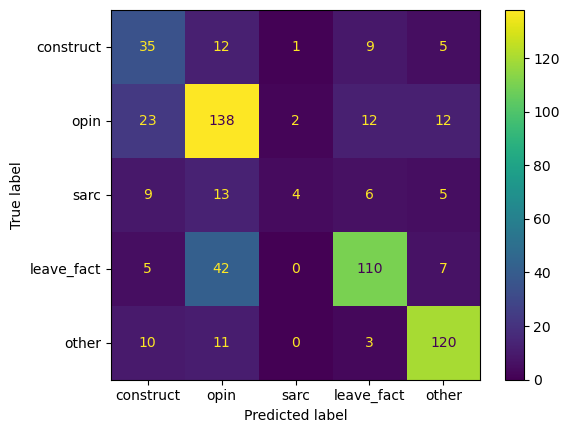

In [27]:
# Scikit-learn also provides a function for the confusion matrix including plotting.
cm = confusion_matrix(predictions.label, predictions.pred_label)
disp = ConfusionMatrixDisplay(cm, display_labels=label_to_id.keys())

disp.plot()
plt.show()

In [28]:
# In the following, let's calculate the ROC curves per argumentation strategy using scikit-
# learn's roc_curve function and collect the results in a dictionary called roc_dict.
roc_dict = {}

for label in label_to_id.keys():
    binary_label = [1 if x == label_to_id[label] else 0 for x in preds.label]
    roc_dict[label] = roc_curve(binary_label, preds[f"raw_pred_{label_to_id[label]}"])  # calculate roc_curve

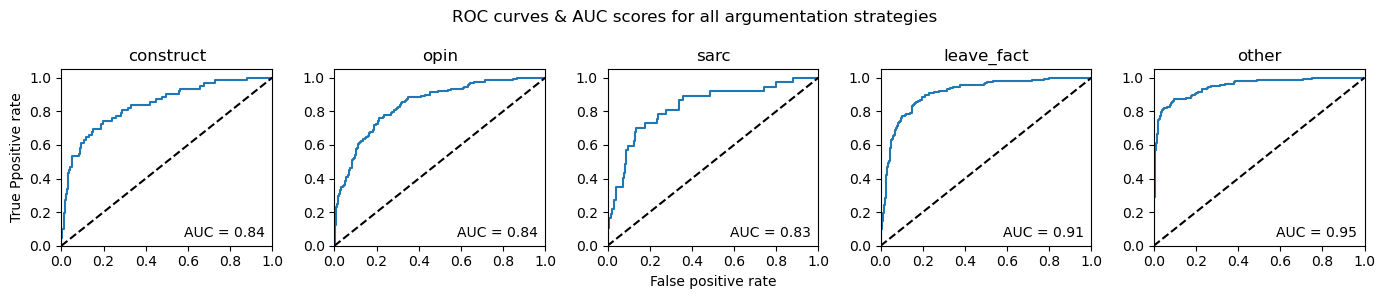

In [29]:
# This code was inspired by https://www.geeksforgeeks.org/machine-learning/how-to-plot-roc-curve-in-python/.
# plotting the ROC curves
fig, axs = plt.subplots(1, 5, figsize=(14, 3))

for ax, label in zip(axs, roc_dict.keys()):  # iterate over all strategy classes
    fpr, tpr, thresholds = roc_dict[label]  # retrieve results from roc dictionary
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], 'k--', label='No Skill')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title(label)
    ax.text(0.58, 0.05, f"AUC = {round(auc(fpr, tpr), 2)}")

axs[2].set_xlabel('False positive rate')
axs[0].set_ylabel('True Ppositive rate')

fig.suptitle("ROC curves & AUC scores for all argumentation strategies")
fig.tight_layout()

### Evaluation During Model Development

Instead of calculating model performance on a held-out test set, during model training, the data is split into a training and validation set multiple times (n-fold cross-validation). In multiple rounds, the model is trained on the respective training split and evaluated on the respective validation split. This not only allows to select the best out of n models, but also to calculate a confidence interval of model performance over all n splits.

We demonstarte how to use Python's scikit-learn library to split the data n times into training, validation and test set.

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit
import os
import random
from pathlib import Path

In [31]:
# First, let's load example data. This is data with one label.
one_label = pd.read_csv("data/one_label.csv", sep=";")
one_label.head()

,label,text
0,construct,"Die Idee is wohl, dass Anschläge von den Täter..."
1,sarc,"O, schaut mal, wie viele PKK-Fans hier in Deut..."
2,leave_fact,"Ehrlich sein zum Türken, aber dann Doppelmoral..."
3,other,Ihr seid voll durchgedreht und total verrückt ...
4,construct,Es hat einen Angriff auf ne Moschee gegeben.


In the following, we shuffle and split the data into three pieces (training, validation, test set) for five times. First, we separate 15% of the data to serve as a held-out test set, on which we calculate final model performance. Second, out of the remaining samples, we split an equal amount (15% from the total data) to serve as validation set during training. Third, the remaining 70% of the data serves as training data.

In [32]:
def split_data(df, n=5, test_frac=0.15, eval_frac=0.15, dirname="data/stratified-shuffle-split/"):
    """ Splits data into n folds with training, evaluation and test set and saves to files.
    df:        dataframe with columns text, label
    n:         number of splits
    test_frac: fraction of data set aside for testing
    eval_frac: fraction of data set aside for evaluation
    dirname:   directory to store splits
    """
    # By splitting the data in n different ways, we are able to train
    # n different models, letting us choose the best out of five.
    
    # For each of the n models we train, we set aside a training, validation and
    # (held-out) test set. The parameters test_frac and eval_frac specify the
    # fraction of data that is set aside for validation and testing.
    
    # set a seed to make the splits reproducible
    # iterate over n seeds = n splits
    for s, seed in enumerate(random.sample(range(1, 1000), n)):
        
        # First, we get the test split.
        # We use scikit-learn's stratified shuffle split
        # -> shuffle, because it shuffles the data before splitting
        # -> stratified, because it preserves the class distributions across train, validation, and test set
        sss = StratifiedShuffleSplit(
            n_splits=1, 
            test_size=eval_frac, 
            random_state=seed
        )
        sss.get_n_splits(df["text"], df["label"])
        # The .split() function separates the test indices from the remaining indices, here called tmp_index.
        for tmp_index, test_index in sss.split(df["text"], df["label"]):
            X_tmp, X_test = df["text"].loc[tmp_index], df["text"].loc[test_index]
            y_tmp, y_test = df["label"].loc[tmp_index], df["label"].loc[test_index]
    
        tmp = pd.concat([X_tmp, y_tmp], axis=1).reset_index(drop=True)  # keep the remaining data
        testdata = pd.concat([X_test, y_test], axis=1)  # create the test dataframe
    
        # Second, we get the validation split ...
        # ... and third, keep the rest as training data.
        sss = StratifiedShuffleSplit(
            n_splits=1, 
            test_size=eval_frac / (1 - test_frac),  # recalculate the percentage points based on the reduced sample size
                                                    # i.e., all data minus the test set
            random_state=s + 10
        )
        sss.get_n_splits(tmp["text"], tmp["label"])
        # Again, the .split() function separates the validation indices from the remaining indices, now the indices for the training data.
        for train_index, eval_index in sss.split(tmp["text"], tmp["label"]):
            X_train, X_eval = tmp["text"].loc[train_index],\
                              tmp["text"].loc[eval_index]
            y_train, y_eval = tmp["label"].loc[train_index],\
                              tmp["label"].loc[eval_index]
    
            traindata = pd.concat([X_train, y_train], axis=1)  # create training dataframe
            evaldata = pd.concat([X_eval, y_eval], axis=1)  # create validation dataframe
    
        # save the splits
        if not os.path.exists(dirname):
            os.makedirs(dirname)
        
        traindata.to_csv(Path(dirname + f"train_split_{s+1}.csv"), index=False, sep=";")
        testdata.to_csv(Path(dirname + f"test_split_{s+1}.csv"), index=False, sep=";")
        evaldata.to_csv(Path(dirname + f"eval_split_{s+1}.csv"), index=False, sep=";")

In [33]:
split_data(one_label)

In [34]:
# Let's do a sanity check:
! ls "data/stratified-shuffle-split/"
# We have 15 files saved; train, eval, and test for each of the five splits.

eval_split_1.csv  eval_split_5.csv  test_split_4.csv  train_split_3.csv
eval_split_2.csv  test_split_1.csv  test_split_5.csv  train_split_4.csv
eval_split_3.csv  test_split_2.csv  train_split_1.csv train_split_5.csv
eval_split_4.csv  test_split_3.csv  train_split_2.csv


In [35]:
# Let's evaluate the amount of samples in split 1:
train_1 = pd.read_csv("data/stratified-shuffle-split/train_split_1.csv", sep=";")
eval_1 = pd.read_csv("data/stratified-shuffle-split/eval_split_1.csv", sep=";")
test_1 = pd.read_csv("data/stratified-shuffle-split/test_split_1.csv", sep=";")

print(f"There as {len(one_label)} samples in the entire data.")
print(f"There as {len(train_1)} samples in the training data.")
print(f"There as {len(eval_1)} samples in the validation data.")
print(f"There as {len(test_1)} samples in the test data.")

There as 499 samples in the entire data.
There as 349 samples in the training data.
There as 75 samples in the validation data.
There as 75 samples in the test data.


## Improving Model Performance

### Masked Language Modeling

Masked Language Modeling is a tool to accustom a base model to one's own data. In our working example, our goal was to classify German tweets. Therefore, we chose a base model that was trained on Twitter data and is multilingual. To make sure that it better understands the German tweets in our dataset, we performed MLM. MLM is a self-supervised task, that is the model learns only from text without labels. To this end, during the training process, a prespecified percentage of tokens is masked and the model is supposed to predict the masked tokens.

In the following, we demonstrate MLM on our sample data. This is merely a demonstration. For successful MLM, more data and training epochs are needed.

This part of the tutorial is based on the [transformers library MLM tutorial](https://huggingface.co/docs/transformers/tasks/masked_language_modeling).

In [36]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from transformers import AutoModelForMaskedLM, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
import math

/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
# First, we'll set a few parameters that controll the training process
EPOCHS = 1  # how often we cycle through the entire data while training
BATCH_SIZE = 8  # how many samples the model processes at once
LR = 2e-5  # the learning rate, how strongly the model's weights are adjusted based on the gradient
WEIGHT_DECAY = 0.01  # penalty for large weights (which result in overfitting)
MODEL = "cardiffnlp/twitter-xlm-roberta-base"  # the model we would like to finetune
NEW_MODEL_NAME = "MLM-demo"  # the new model name
OUTPUT_DIR = "finetuned_models/"  # the directory, where we store the finetuned model

In [38]:
# Let's load our data.
# This is just text without labels.
data = pd.read_csv("data/sample_pool.csv", usecols=["text"], sep=";")[:5000]  # keeping only 5000 samples for demo purposes
data = data.dropna()

# We divide the data into a 80% training and a 20% validation split ...
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
N = len(data)  # 5000
val_frac = 0.2

# ... and store it in a specific class, the "DatasetDict".
train = Dataset.from_pandas(data[0: int(N * (1 - val_frac))])  # data[0:4000]
val = Dataset.from_pandas(data[int(N * (1 - val_frac)):])  # data[4000:]

datasets = DatasetDict()
datasets['train'] = train
datasets['validation'] = val

In [39]:
# Now, we tokenize our text with the according tokenizer of our model of choice.
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

def tokenize_function(examples):
    return tokenizer(examples["text"],
                     truncation=True,
                     padding=True,
                     max_length=512)  # making sure to set the max_length parameter to a value the model can handle

# apply the tokenize function to the training and validation data
tokenized_data = datasets.map(
    tokenize_function, 
    batched=True,  # for faster processing
    remove_columns=["text"]  # removing the raw text, which we don't need anymore
)

Map: 100%|████████████████████████| 1000/1000 [00:00<00:00, 37168.06 examples/s]


In [40]:
# During the Masked Language Modeling, the model expects sequences of tokens of equal length.
# We therefore concatenate the whole (tokenized) text, and cut it into pieces of the size "block_size".
# As such, we don't respect sentence boundaries. A sequence can begin and end in the middle of a sentence.
def group_texts(examples):
    """ concatenates the entire text (i.e., tokens) and cuts it into equal pieces """
    block_size = 128
    # concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the remainder of the text.
    total_length = (total_length // block_size) * block_size
    # split by chunks of total_length
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    return result

# apply the group texts function to the training and validation data
tokenized_data = tokenized_data.map(
    group_texts,
    batched=True
)


Map: 100%|█████████████████████████| 1000/1000 [00:00<00:00, 4254.86 examples/s]


In [41]:
# We load the pre-trained (but not finetuned) base model, we specified above ...
model = AutoModelForMaskedLM.from_pretrained(MODEL)

# ... and put all training arguments (i.e., parameters) in a specific class called "TrainingArguments".
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR + NEW_MODEL_NAME,  # the directory where the model is stored
    num_train_epochs=EPOCHS,  # number of training epochs
    per_device_train_batch_size=BATCH_SIZE,  # batch sizes
    per_device_eval_batch_size=BATCH_SIZE,
    eval_strategy="epoch",  # The model is evaluated after each epoch.
    save_strategy="no",  # No intermediate training steps are saved (only final model).
    learning_rate=LR,  # learning rate
    weight_decay=WEIGHT_DECAY,  # weight decay
    dataloader_pin_memory=False,
    logging_strategy="epoch"  # recording the training loss (after each epoch)
)

Loading weights: 100%|█| 204/204 [00:00<00:00, 2164.52it/s, Materializing param=
The tied weights mapping and config for this model specifies to tie roberta.embeddings.word_embeddings.weight to lm_head.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie lm_head.bias to lm_head.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
XLMRobertaForMaskedLM LOAD REPORT from: cardiffnlp/twitter-xlm-roberta-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [42]:
# The "data collator" prepares batches of data to pass to the model during training.
# Here, it further masks 15% of tokens in the training data -> This is the Masked Language Modeling part.
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

# We instantiate the "Trainer" ...
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    data_collator=data_collator,
)

# check whether training runs on GPU or CPU
print(f"Using device: {trainer.model.device}")

# ... and train the model with the above specifications.
trainer.train()

# Finally, we evaluate the loss and perplexity.
# Perplexity measures how well the model predicts the (unseen) validation data.
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

trainer.save_model(OUTPUT_DIR + NEW_MODEL_NAME)

Using device: mps:0


Epoch,Training Loss,Validation Loss
1,3.588299,2.952815


Perplexity: 19.94


Writing model shards: 100%|███████████████████████| 1/1 [00:00<00:00,  1.21it/s]


### Tuning Model Hyperparameters

Hyperparameters are a set of parameters that need to be chosen to steer the model training process. There are usually a number of parameters to set and when trying out different values for each of them, the parameter space quickly becomes large. Here, we can conduct a random grid search: We define a range of values for each of the parameters we would like to tune and randomly sample combinations of the parameters to evaluate during model training.

In the following, we demonstrate how to conduct a random grid search using scikit-learn's ParameterSampler. We take the model from above (twitter-xlm-roberta-base) and train it to classify tweets into different argumentation strategies.

In [43]:
import numpy as np
from sklearn.model_selection import ParameterSampler
from transformers import AutoModelForSequenceClassification
import evaluate

In [44]:
# Let's load one training and validation split from earlier ("Evaluation During Model Development").
# Hyperparameter tuning can be combined with n-fold cross validation, however, we only focus on
# one training and validation set here for simplicity.
train_df = pd.read_csv("data/stratified-shuffle-split/train_split_1.csv", sep=";")
eval_df = pd.read_csv("data/stratified-shuffle-split/eval_split_1.csv", sep=";")

train_df.head(2)

,text,label
0,"Und die Türkei meint, von der deutschen freien...",opin
1,"Dadurch werden alle, die für Trump gestimmt ha...",construct


In [45]:
# We replace the labels in natural language with numerical labels.
label_to_id = {
    "construct": 0,
    "opin": 1,
    "sarc": 2,
    "leave_fact": 3,
    "other": 4,
}

train_df["label"] = train_df["label"].map(label_to_id)
eval_df["label"] = eval_df["label"].map(label_to_id)

train_df.head(2)

,text,label
0,"Und die Türkei meint, von der deutschen freien...",1
1,"Dadurch werden alle, die für Trump gestimmt ha...",0


In [46]:
# We transform the pandas dataframe to a Dataset instance and tokenize the text with our tokenize function from above (cell 38).
train_data = Dataset.from_pandas(train_df)
eval_data = Dataset.from_pandas(eval_df)

train_data = train_data.map(tokenize_function, batched=True)
eval_data = eval_data.map(tokenize_function, batched=True)

Map: 100%|████████████████████████████| 75/75 [00:00<00:00, 17256.72 examples/s]


In [47]:
# Now we can define the parameter grid. We tune four hyperparameters.
param_grid = {
    "learning_rate": [1e-5, 5e-5, 1e-4],
    "per_device_train_batch_size": [4, 8, 16],  # for demonstration; in reality choose higher values, e.g. [32, 64, 128, 256, 512]
    "label_smoothing_factor": [0.1, 0.2, 0.3],
    "weight_decay": [0.001, 0.0025, 0.005],
}

# number of random combinations to try
num_combinations = 2

random_search = list(ParameterSampler(param_grid, n_iter=num_combinations))  # sampling our parameter combinations
print("Randomly sampled hyperparameter sets:")
for params in random_search:
    print(params)

Randomly sampled hyperparameter sets:
{'weight_decay': 0.001, 'per_device_train_batch_size': 8, 'learning_rate': 1e-05, 'label_smoothing_factor': 0.2}
{'weight_decay': 0.001, 'per_device_train_batch_size': 4, 'learning_rate': 1e-05, 'label_smoothing_factor': 0.1}


In [48]:
# We define a function for the evaluation metric, we'd like to apply during training, here the micro F1 score.
metric = evaluate.load("f1")

def compute_metrics(eval_preds):
    """ Function to evaluate the micro F1 score """
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="micro")

In [49]:
# Now, we can iterate over the sampled parameter combinations training different models and compare their performance.
best_f1 = -1
best_params = None

for i, params in enumerate(random_search):
    print(f"--- Trial {i+1}/{len(random_search)} ---")
    print(f"Hyperparameters: {params}")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL,  # load "twitter-xlm-roberta-base"
        num_labels=one_label["label"].nunique())

    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR + f"random_grid_search/trial_{i}",  # first, define the fixed parameters
        eval_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        per_device_eval_batch_size=BATCH_SIZE,  # 8
        num_train_epochs=EPOCHS,  # 1
        learning_rate=params["learning_rate"],  # then specify the parameters which vary
        per_device_train_batch_size=params["per_device_train_batch_size"],
        label_smoothing_factor=params["label_smoothing_factor"],
        weight_decay=params["weight_decay"]
    )
    
    # train the model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=eval_data,
        compute_metrics=compute_metrics,
    )

    # check whether training runs on GPU or CPU
    print(f"Using device: {trainer.model.device}")
    
    # evaluate the model
    trainer.train()
    eval_results = trainer.evaluate()

    trainer.save_model(OUTPUT_DIR + f"random_grid_search/trial_{i}")

    current_f1 = eval_results["eval_f1"]
    print(f"Validation F1: {current_f1:.4f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        best_params = params

--- Trial 1/2 ---
Hyperparameters: {'weight_decay': 0.001, 'per_device_train_batch_size': 8, 'learning_rate': 1e-05, 'label_smoothing_factor': 0.2}


Loading weights: 100%|█| 197/197 [00:00<00:00, 2388.42it/s, Materializing param=
XLMRobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-xlm-roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.decoder.weight          | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.decoder.bias            | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly i

Using device: mps:0


/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,F1
1,1.571844,1.530904,0.373333


/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards: 100%|███████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Validation F1: 0.3733
--- Trial 2/2 ---
Hyperparameters: {'weight_decay': 0.001, 'per_device_train_batch_size': 4, 'learning_rate': 1e-05, 'label_smoothing_factor': 0.1}


Loading weights: 100%|█| 197/197 [00:00<00:00, 2097.89it/s, Materializing param=
XLMRobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-xlm-roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.decoder.weight          | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.decoder.bias            | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly i

Using device: mps:0


/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,F1
1,1.560385,1.475644,0.360000


/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Writing model shards: 100%|███████████████████████| 1/1 [00:00<00:00,  2.50it/s]

Validation F1: 0.3600


In [50]:
print(f"Best F1: {best_f1:.4f}")
print(f"Best Hyperparameters: {best_params}")

Best F1: 0.3733
Best Hyperparameters: {'weight_decay': 0.001, 'per_device_train_batch_size': 8, 'learning_rate': 1e-05, 'label_smoothing_factor': 0.2}


The initial parameter search can be followed by a fine-grained search in a small area of values around the best combination found in the first cycle.

## Focus Model Performance: Training on Confident Examples

Our labeled dataset contains tweets with one, but also more than one human label. In the project that serves as an example for this tutorial, interrater agreement pointed towards considerable ambiguity in the concepts we were trying to measure (e.g., argumentation strategy). Therefore, when training the transformer classification model on all data with one label, this introduced may confusion text, label pairs impairing model performance.

For data with more than one human label, we were able to identify tweets where annotators agreed calling them "confident examples". Training the model on confident examples only resulted in significant performance improvement. Furthermore, to make use of as much labeled data as possible, we trained a preliminary model to classify tweets with one human label identifying more confident examples where human and preliminary classifier agreed.

The figure below illustrates Training on Confident Examples. We further supplemented the still underrepresented classes in the training data with augmented samples for which we used back translation. We will not demonstrate back translation here, as today a common augmentation strategy is to use LLMs to rephrase the texts to add to the training data. For an example how to prompt an LLM via its API, please refer to the section on "LLMs and Traditional Transformer Models as Classifiers".

<img src="https://raw.githubusercontent.com/Hai-Lina/computational-social-mixed-methods-pipelines/GESIS-methods-hub/figures/confident-examples.png" width="600">

We identified confident examples and trained models in two rounds or until performance did not improve anymore. However, technically more iterations are possible.

In [51]:
from transformers import EarlyStoppingCallback
import torch
from torch import cuda
import shutil

In [52]:
# First, we read data consisting of tweets with multiple labels for argumentation strategy.
df = pd.read_csv("data/multiple_labels.csv", delimiter=";")
df.head()

,label_1,label_2,label_3,label_4,text
0,sarc,sarc,sarc,sarc,@realvibes @CoolMaas Also müssen wir erstmal a...
1,construct,opin,opin,construct,@Max_Muller Jetzt: Unsere Schwierigkeiten sind...
2,opin,construct,opin,opin,@user123 @newsflashxyz @daily_report @global_w...
3,opin,opin,opin,opin,". @LenaMeyer Wer Europa festigen will, darf da..."
4,other,other,sarc,other,"@maxmiller @beauty.sight @newsflash Jo, aber e..."


#### Identify confident examples (round 1)

In [53]:
# We write a function that determines the level of agreement between annotators.
def calculate_confidence(row):
    """
    Determine the rater agreement across four ratings. The function expects
    a row of a data frame with four labels. It returns the agreement level
    depending on the number of labels that are the same.
    """
    labels = list(row[[f"label_{i}" for i in range(1, 5)]].values)
    # all raters agree
    if len(set(labels)) == 1: 
        return "unanimous"
    # two raters agree, the other raters disagree
    elif len(set(labels)) == 3: 
        return "weak-majority"
    # all raters disagree
    elif len(set(labels)) == 4: 
        return "disagreement"
    # raters are split between two labels
    elif len(set(labels)) == 2 and labels.count(labels[0]) == 2: 
        return "split"
    # three out of four raters agree
    else:
        return "majority"

In [54]:
# calculate the rater confidence and add it to the data frame as an additional column
df["rater_confidence"] = df.apply(calculate_confidence, axis=1)
df.head()

,label_1,label_2,label_3,label_4,text,rater_confidence
0,sarc,sarc,sarc,sarc,@realvibes @CoolMaas Also müssen wir erstmal a...,unanimous
1,construct,opin,opin,construct,@Max_Muller Jetzt: Unsere Schwierigkeiten sind...,split
2,opin,construct,opin,opin,@user123 @newsflashxyz @daily_report @global_w...,majority
3,opin,opin,opin,opin,". @LenaMeyer Wer Europa festigen will, darf da...",unanimous
4,other,other,sarc,other,"@maxmiller @beauty.sight @newsflash Jo, aber e...",majority


In [55]:
# We will drop all examples were the rater confidence is "split" or "disagreement".
df["rater_confidence"].value_counts()

rater_confidence
majority         308
unanimous        286
weak-majority    180
split            124
disagreement      19
Name: count, dtype: int64

In [56]:
# select only examples where two or more raters agree (no split decisions!)
df = df[df["rater_confidence"].isin(["unanimous", "majority", "weak-majority"])]
df.head()

,label_1,label_2,label_3,label_4,text,rater_confidence
0,sarc,sarc,sarc,sarc,@realvibes @CoolMaas Also müssen wir erstmal a...,unanimous
2,opin,construct,opin,opin,@user123 @newsflashxyz @daily_report @global_w...,majority
3,opin,opin,opin,opin,". @LenaMeyer Wer Europa festigen will, darf da...",unanimous
4,other,other,sarc,other,"@maxmiller @beauty.sight @newsflash Jo, aber e...",majority
5,leave_fact,other,other,opin,@xyzauthor @frauexample seitdem unsere Politik...,weak-majority


In [57]:
# create a new column in the data frame with the majority label
df["label"] = np.nan
df["label"] = df["label"].astype("object")
for i, row in df[[f"label_{i}" for i in range(1, 5)]].iterrows():
    df.loc[i, "label"] = row.value_counts().index[0]
df.head()

,label_1,label_2,label_3,label_4,text,rater_confidence,label
0,sarc,sarc,sarc,sarc,@realvibes @CoolMaas Also müssen wir erstmal a...,unanimous,sarc
2,opin,construct,opin,opin,@user123 @newsflashxyz @daily_report @global_w...,majority,opin
3,opin,opin,opin,opin,". @LenaMeyer Wer Europa festigen will, darf da...",unanimous,opin
4,other,other,sarc,other,"@maxmiller @beauty.sight @newsflash Jo, aber e...",majority,other
5,leave_fact,other,other,opin,@xyzauthor @frauexample seitdem unsere Politik...,weak-majority,other


In [58]:
# Now we can drop the individual labels by the four raters and only retain the majority label.
df = df.reset_index()
df = df[["text", "label"]]
df.head()

,text,label
0,@realvibes @CoolMaas Also müssen wir erstmal a...,sarc
1,@user123 @newsflashxyz @daily_report @global_w...,opin
2,". @LenaMeyer Wer Europa festigen will, darf da...",opin
3,"@maxmiller @beauty.sight @newsflash Jo, aber e...",other
4,@xyzauthor @frauexample seitdem unsere Politik...,other


#### Prepare data for training

In [59]:
# To train the BERT model, we need to replace the string description of classes 
# with numerical class labels (see label_to_id cell 44).
df["label"] = df["label"].map(label_to_id)
df.head()

,text,label
0,@realvibes @CoolMaas Also müssen wir erstmal a...,2
1,@user123 @newsflashxyz @daily_report @global_w...,1
2,". @LenaMeyer Wer Europa festigen will, darf da...",1
3,"@maxmiller @beauty.sight @newsflash Jo, aber e...",4
4,@xyzauthor @frauexample seitdem unsere Politik...,4


In [60]:
# We use the split function from earlier to create train, evaluation, and test splits (see "Evaluation During Model Development").
split_data(df, dirname="data/confident_examples/")

#### Train a BERT classifier on confident examples

In [61]:
# Training parameters
# Note: training for 10 epochs and 5 splits takes about 1 hour on a relatively
# powerful laptop. On a GPU training takes only a few minutes. The number of
# epochs and splits has been set to 1 here for illustration purpuses.
EPOCHS = 1  # 10
BATCH_SIZE = 128  # reduce if running out of memory
WARMUP_STEPS = 100
WEIGHT_DECAY = 0.0025
LABEL_SMOOTHING = 0.2
EVAL_STEPS = 5 
DATA_SPLITS = 1  # 5
 
DATA_SRC = "data/confident_examples/"

datatypes = ['train','eval','test']
splits = [1, 2, 3, 4, 5]
dataset_dict = {i: {} for i in splits}

In [62]:
# read the different data splits and sort them into a dictionary
for j in splits:
    for i in datatypes:
        dataset_dict[j][i] = {}
        data = pd.read_csv(
            Path(DATA_SRC + f"{i}_split_{j}.csv"),
            dtype={"text": str, "label": int},
            delimiter=";"
        )
        dataset_dict[j][i]["text"] = list(data["text"].values)
        dataset_dict[j][i]["labels"] = list(data["label"].values)

In [63]:
class MyDataset(torch.utils.data.Dataset):
    """ Custom data set class to store the data """
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [64]:
# Iterate over all data splits, train the model using the training data for
# training and validation data for model evaluation during training. The test
# data set is used at the very end to test the performance of the model on 
# unseen data. The report with different performance metrics is saved to the
# "results" folder. The trained model is saved to the "finetuned_models" folder.
for split in splits[0:DATA_SPLITS]:
    # load the tokenizer and encode the train, eval and test data sets of the given split
    train_encodings = tokenize_function({"text": dataset_dict[split]['train']['text']})
    eval_encodings = tokenize_function({"text": dataset_dict[split]['eval']['text']})
    test_encodings = tokenize_function({"text": dataset_dict[split]['test']['text']})

    # package the encoded datasets into a dataset class
    train_dataset = MyDataset(train_encodings, dataset_dict[split]['train']['labels'])
    eval_dataset = MyDataset(eval_encodings, dataset_dict[split]['eval']['labels'])
    test_dataset = MyDataset(test_encodings, dataset_dict[split]['test']['labels'])

    # set the training arguments
    training_args = TrainingArguments(
        # output_dir="finetuned_models",          # output directory for logging, saves intermediate training steps
                                                  # for sparsity, here we only save the final model (see below)
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        warmup_steps=WARMUP_STEPS,                # steps for which the learning rate is gradually improved until its final value
        weight_decay=WEIGHT_DECAY,
        label_smoothing_factor=LABEL_SMOOTHING,
        metric_for_best_model="eval_loss",
        eval_strategy="steps",
        eval_steps=EVAL_STEPS,                    # number of steps after which model is evaluated on eval dataset
        save_strategy="no",
        seed=42                                   # set a seed for reproducibility of the model
    )

    # load the pretrained model (twitter-xlm-roberta-base)
    num_labels = len(set(dataset_dict[split]["train"]["labels"]))
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=num_labels)
    
    # initialize the trainer with the model, training arguments, training data
    # set, validation data set, metric for evaluations, and the early stopping
    # callback which will stop training if the performance does not improve
    # over five consecutive training steps
    trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset = train_dataset,
            eval_dataset = eval_dataset,
            compute_metrics = compute_metrics,
            callbacks = [EarlyStoppingCallback(5, 0)]
    )

    print(f"Using device: {trainer.model.device}")

    # execute the training and save the trained model
    trainer.train()
    model_savename = f"{MODEL.split('/')[-1]}_split-{split}"
    trainer.save_model(Path("finetuned_models", model_savename))  # save best model

    # calculate the performance of the trained model on the held-out test dataset
    test_preds_raw, test_labels, _ = trainer.predict(test_dataset)
    test_preds = np.argmax(test_preds_raw, axis=-1)
    report = classification_report(test_labels, test_preds, digits=3, output_dict=True, zero_division=0)
    print(classification_report(test_labels, test_preds, digits=3, zero_division=0))

    # save the model performance report for later inspection
    report_df = pd.DataFrame(report).transpose()   
    report_savename = f"report_{MODEL.split('/')[-1]}_epochs-{EPOCHS}_bs-{BATCH_SIZE}_split-{split}.csv"
    report_df.to_csv(Path("results", report_savename), index=False)

# Warning notes:
# Insufficient memory: Reduce the batch size.
# For Mac users, pin_memory not supported: Raised due to different architecture of Apple GPUs, can be ignored.
# Precision is zero for some steps: Happens, if the model fails to predict at least one class entirely.

Loading weights: 100%|█| 197/197 [00:00<00:00, 2061.43it/s, Materializing param=
XLMRobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-xlm-roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.decoder.weight          | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.decoder.bias            | UNEXPECTED | 
classifier.dense.bias           | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly i

Using device: mps:0


/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Step,Training Loss,Validation Loss,F1
5,No log,1.634410,0.232759


Writing model shards: 100%|███████████████████████| 1/1 [00:00<00:00,  1.76it/s]
/Users/alinaherderich/anaconda3/envs/CSMM-pipeline/lib/python3.12/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


              precision    recall  f1-score   support

           0      0.000     0.000     0.000        13
           1      0.000     0.000     0.000        35
           2      0.000     0.000     0.000        11
           3      0.000     0.000     0.000        31
           4      0.233     1.000     0.378        27

    accuracy                          0.231       117
   macro avg      0.047     0.200     0.076       117
weighted avg      0.054     0.231     0.087       117



In [65]:
# remove the directory where checkpoints are saved by default
# (We didn't save any checkpoints, just the final model.)
shutil.rmtree("trainer_output")

#### Identify more confident examples (round 2+)

In [66]:
# We can now use the preliminary BERT model trained previously to identify new confident
# examples on data with only a single human label. Therefore, we'll grab our data from
# earlier with one label only.
one_label.head()

,label,text
0,construct,"Die Idee is wohl, dass Anschläge von den Täter..."
1,sarc,"O, schaut mal, wie viele PKK-Fans hier in Deut..."
2,leave_fact,"Ehrlich sein zum Türken, aber dann Doppelmoral..."
3,other,Ihr seid voll durchgedreht und total verrückt ...
4,construct,Es hat einen Angriff auf ne Moschee gegeben.


#### Reload preliminary classifier

In [67]:
# tokenize texts we would like to classify
tokenized_text = tokenize_function({"text": one_label.text.to_list()})

# convert to PyTorch tensors manually
inputs = {k: torch.tensor(v) for k, v in tokenized_text.items()}

# We can load the prelimiary classifier from the checkpoint saved in "finetuned_models" ...
model = AutoModelForSequenceClassification.from_pretrained("finetuned_models/twitter-xlm-roberta-base_split-1")

# ... and use it to classify our data with only a single label.
with torch.no_grad():
    logits = model(**inputs).logits

Loading weights: 100%|█| 201/201 [00:00<00:00, 1810.42it/s, Materializing param=


In [68]:
# create a new column in the dataframe containing the label inferred with the preliminary classifier
one_label["model"] = logits.argmax(axis=1).numpy()
one_label["model"] = one_label.model.replace({v: k for k, v in label_to_id.items()})

one_label.head()

,label,text,model
0,construct,"Die Idee is wohl, dass Anschläge von den Täter...",other
1,sarc,"O, schaut mal, wie viele PKK-Fans hier in Deut...",other
2,leave_fact,"Ehrlich sein zum Türken, aber dann Doppelmoral...",other
3,other,Ihr seid voll durchgedreht und total verrückt ...,other
4,construct,Es hat einen Angriff auf ne Moschee gegeben.,other


In [69]:
# retain only tweets where the human and the prelimiary model agree
new_confident_examples = one_label[one_label.label == one_label.model]
new_confident_examples = new_confident_examples.reset_index().drop(columns=["model", "index"])

print(f"Using the prelimiary BERT classifier, we identified {len(new_confident_examples)} new confident examples.")
new_confident_examples.head()

# The newly identified confident examples can now be used in a second round of training for the BERT model.

Using the prelimiary BERT classifier, we identified 46 new confident examples.


,label,text
0,other,Ihr seid voll durchgedreht und total verrückt ...
1,other,"hätt glaub ich mal gedacht, du gönnst dir endl..."
2,other,Deutschland Mischlingskind!
3,other,@MaxMuellerXYZ @globalnews und unsere Kultur g...
4,other,die sollten alle in den Irak ziehen


<b>To continue with the tutorial, please refer to notebook "3_statistical_analysis".</b>